# Lecture 2B: Unsupervised Text Analysis — Clustering and Topic Modeling

## Introduction

Text data pervades economic and social science research: policy documents, firm descriptions, job postings, news articles, social media posts, and academic papers. Unlike structured numerical data, text requires transformation into numerical representations before we can apply machine learning techniques.

This lecture focuses on **unsupervised learning** methods for text analysis, which discover structure in data without predefined labels. We address two fundamental tasks:

1. **Clustering**: Grouping similar documents together based on their content
2. **Topic Modeling**: Discovering latent thematic structures in a corpus

We will use **academic paper abstracts** from the OpenAlex database as our primary dataset. Scientific publications provide a rich domain for text analysis: abstracts exhibit distinct thematic patterns across disciplines and methodological approaches, making them ideal for demonstrating unsupervised text analysis techniques.

### Learning Objectives

Upon completion of this lecture, you will be able to:

- Transform text into numerical representations using Bag of Words and TF-IDF
- Measure document similarity using cosine distance
- Apply K-Means clustering to discover natural groupings in text corpora
- Implement hierarchical clustering and interpret dendrograms
- Use Latent Dirichlet Allocation (LDA) for topic discovery
- Evaluate and select appropriate numbers of clusters and topics

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time

# Text processing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

# Dimensionality reduction for visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Plotting settings
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

---

## Retrieve Data  from OpenAlex

### About OpenAlex

OpenAlex is a free and open catalog of the world's scholarly papers, researchers, journals, and institutions. It allows access to bibliometric data through a REST API, making it an excellent resource for scientometric research and text analysis applications.

We will retrieve a random sample of 500 academic papers with their abstracts, titles, and metadata.

In [39]:
def fetch_openalex_papers(n_papers=500, per_page=200):
    """
    Fetch random papers from OpenAlex API with abstracts.
    
    Parameters:
    -----------
    n_papers : int
        Total number of papers to retrieve
    per_page : int
        Number of papers per API request (max 200)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing paper metadata and abstracts
    """
    base_url = "https://api.openalex.org/works"
    
    # Parameters for the API request
    # We filter for papers that have abstracts and are from recent years
    params = {
        "filter": "has_abstract:true,publication_year:2020-2024,type:article",
        "per_page": per_page,
        "select": "id,title,abstract_inverted_index,publication_year,cited_by_count,primary_location,primary_topic"
    }
    
    all_papers = []
    cursor = "*"
    
    print(f"Fetching {n_papers} papers from OpenAlex...")
    
    while len(all_papers) < n_papers:
        params["cursor"] = cursor
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            results = data.get("results", [])
            if not results:
                break
                
            for paper in results:
                # Reconstruct abstract from inverted index
                abstract = reconstruct_abstract(paper.get("abstract_inverted_index", {}))
                
                if abstract and len(abstract) > 100:  # Ensure meaningful abstract
                    # Replace inverted index with reconstructed abstract
                    paper['abstract'] = abstract
                    del paper['abstract_inverted_index']
                    all_papers.append(paper)
                    
            # Get next cursor for pagination
            meta = data.get("meta", {})
            cursor = meta.get("next_cursor")
            
            if not cursor:
                break
                
            print(f"  Retrieved {len(all_papers)} papers...")
            time.sleep(0.1)  # Respect rate limits
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break
    
    df = pd.DataFrame(all_papers[:n_papers])
    print(f"\nSuccessfully retrieved {len(df)} papers with abstracts.")
    return df


def reconstruct_abstract(inverted_index):
    """
    Reconstruct abstract text from OpenAlex inverted index format.
    
    OpenAlex stores abstracts as inverted indices mapping words to their positions.
    This function reconstructs the original text.
    """
    if not inverted_index:
        return ""
    
    # Create position -> word mapping
    position_word = {}
    for word, positions in inverted_index.items():
        for pos in positions:
            position_word[pos] = word
    
    # Sort by position and join words
    if not position_word:
        return ""
    
    max_pos = max(position_word.keys())
    words = [position_word.get(i, "") for i in range(max_pos + 1)]
    return " ".join(words)

In [40]:
# Fetch 500 random papers from OpenAlex
papers_df = fetch_openalex_papers(n_papers=500)

Fetching 500 papers from OpenAlex...
  Retrieved 132 papers...
  Retrieved 264 papers...
  Retrieved 388 papers...
  Retrieved 508 papers...

Successfully retrieved 500 papers with abstracts.


In [41]:
# Examine the dataset structure
print("Dataset Overview:")
print("="*50)
print(f"Number of papers: {len(papers_df)}")
print(f"\nColumns: {papers_df.columns.tolist()}")
print(f"\nData types:\n{papers_df.dtypes}")
print(f"\nMissing values:\n{papers_df.isnull().sum()}")

Dataset Overview:
Number of papers: 500

Columns: ['id', 'title', 'publication_year', 'cited_by_count', 'primary_location', 'primary_topic', 'abstract']

Data types:
id                  object
title               object
publication_year     int64
cited_by_count       int64
primary_location    object
primary_topic       object
abstract            object
dtype: object

Missing values:
id                  0
title               0
publication_year    0
cited_by_count      0
primary_location    0
primary_topic       0
abstract            0
dtype: int64


In [42]:
papers_df.to_csv('paper_openalexSample.csv', index = False)

In [43]:
papers_df = pd.read_csv('paper_openalexSample.csv')

In [44]:
papers_df['primary_topic'][0] ## is a string!

"{'id': 'https://openalex.org/T10346', 'display_name': 'Magnetic confinement fusion research', 'score': 0.9991000294685364, 'subfield': {'id': 'https://openalex.org/subfields/3106', 'display_name': 'Nuclear and High Energy Physics'}, 'field': {'id': 'https://openalex.org/fields/31', 'display_name': 'Physics and Astronomy'}, 'domain': {'id': 'https://openalex.org/domains/3', 'display_name': 'Physical Sciences'}}"

In [48]:
import ast 
from tqdm.notebook import tqdm
tqdm.pandas()

papers_df['primary_topic'] = papers_df['primary_topic'].progress_apply(lambda x: ast.literal_eval(x)) 
# above you can also avoid on import ast and just use inbuilt eval function
papers_df['primary_topic'][0]

{'id': 'https://openalex.org/T10346',
 'display_name': 'Magnetic confinement fusion research',
 'score': 0.9991000294685364,
 'subfield': {'id': 'https://openalex.org/subfields/3106',
  'display_name': 'Nuclear and High Energy Physics'},
 'field': {'id': 'https://openalex.org/fields/31',
  'display_name': 'Physics and Astronomy'},
 'domain': {'id': 'https://openalex.org/domains/3',
  'display_name': 'Physical Sciences'}}

In [49]:
papers_df['field'] = papers_df['primary_topic'].progress_apply(lambda x: x['field']['display_name'])

  0%|          | 0/500 [00:00<?, ?it/s]

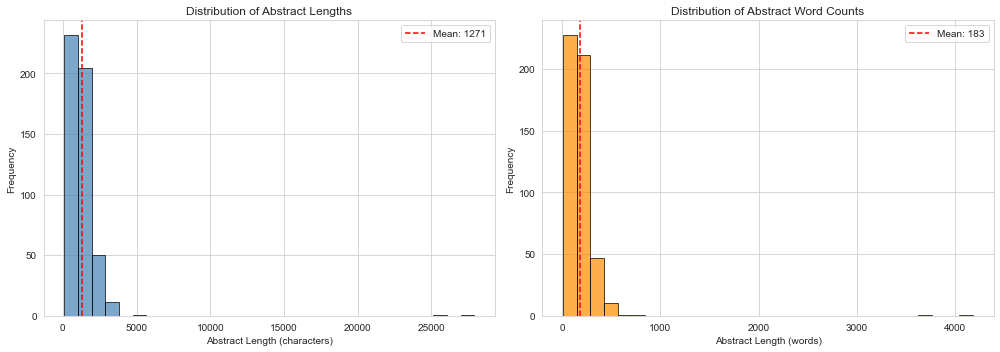


Abstract Statistics:
  Mean length: 1271 characters, 183 words
  Median length: 1118 characters, 158 words


In [45]:
# Examine abstract length distribution
papers_df['abstract_length'] = papers_df['abstract'].str.len()
papers_df['abstract_word_count'] = papers_df['abstract'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Character count distribution
axes[0].hist(papers_df['abstract_length'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Abstract Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Abstract Lengths')
axes[0].axvline(papers_df['abstract_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {papers_df["abstract_length"].mean():.0f}')
axes[0].legend()

# Word count distribution
axes[1].hist(papers_df['abstract_word_count'], bins=30, edgecolor='black', alpha=0.7, color='darkorange')
axes[1].set_xlabel('Abstract Length (words)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Abstract Word Counts')
axes[1].axvline(papers_df['abstract_word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {papers_df["abstract_word_count"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nAbstract Statistics:")
print(f"  Mean length: {papers_df['abstract_length'].mean():.0f} characters, {papers_df['abstract_word_count'].mean():.0f} words")
print(f"  Median length: {papers_df['abstract_length'].median():.0f} characters, {papers_df['abstract_word_count'].median():.0f} words")

In [50]:
# Distribution by field (top 15)
print("Top 15 Research Fields in the Sample:")
print(papers_df['field'].value_counts().head(15))

Top 15 Research Fields in the Sample:
Medicine                                        196
Computer Science                                 82
Biochemistry, Genetics and Molecular Biology     61
Social Sciences                                  23
Mathematics                                      19
Psychology                                       17
Engineering                                      15
Decision Sciences                                13
Physics and Astronomy                            12
Environmental Science                            12
Chemistry                                         9
Economics, Econometrics and Finance               8
Health Professions                                8
Agricultural and Biological Sciences              4
Immunology and Microbiology                       4
Name: field, dtype: int64


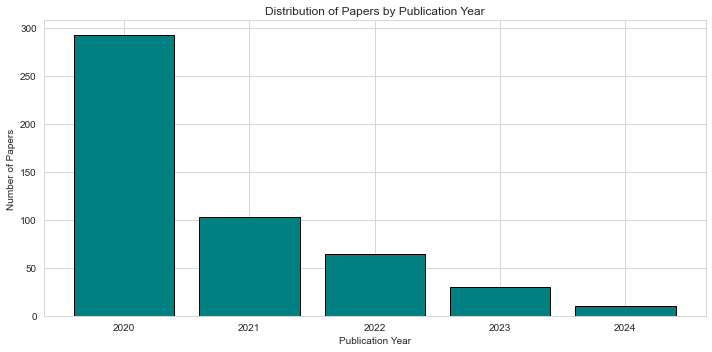

In [52]:
# Distribution by publication year
year_counts = papers_df['publication_year'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
plt.bar(year_counts.index, year_counts.values, color='teal', edgecolor='black')
plt.xlabel('Publication Year')
plt.ylabel('Number of Papers')
plt.title('Distribution of Papers by Publication Year')
plt.tight_layout()
plt.show()

In [54]:
# Example abstract
print("Sample Abstract:")
print("="*50)
sample_idx = 0
print(f"Title: {papers_df.loc[sample_idx, 'title']}")
print(f"Field: {papers_df.loc[sample_idx, 'field']}")
print(f"Year: {papers_df.loc[sample_idx, 'publication_year']}")
print(f"\nAbstract:\n{papers_df.loc[sample_idx, 'abstract'][:500]}...")

Sample Abstract:
Title: Radiation Resistant Camera System for Monitoring Deuterium Plasma Discharges in the Large Helical Device
Field: Physics and Astronomy
Year: 2020

Abstract:
Radiation resistant camera system was constructed for monitoring deuterium plasma discharges in the Large Helical Device (LHD). This system has contributed to safe operation during two experimental campaigns without serious problems due to radiation (neutrons and gamma-rays). The cameras steadily functioned even in the plasma discharge with the maximum neutron emission rate in FY 2017, though some bright specks temporarily appeared on the images. The cameras have been installed in shield boxes w...


---

## Text Representation — From Words to Vectors

### The Document-Term Matrix (DTM)

Machine learning algorithms require numerical inputs. We transform text into vectors through the **Document-Term Matrix**, where:
- Each row represents a document (paper abstract)
- Each column represents a unique term (word)
- Each cell contains a weight indicating the term's importance in that document

### Bag of Words (BoW)

The simplest approach counts raw term frequencies:

$$\text{BoW}(d, t) = \text{count}(t \text{ in } d)$$

### TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF weights terms by their discriminative power across the corpus:

$$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)$$

where:
- $\text{TF}(t, d)$ = term frequency of $t$ in document $d$
- $\text{IDF}(t, D) = \log\frac{|D|}{|\{d \in D : t \in d\}|}$ penalizes common terms

In [55]:
# Simple example to illustrate the transformation
sample_abstracts = [
    "Machine learning algorithms enable pattern recognition in data.",
    "Deep learning neural networks achieve state-of-the-art performance.",
    "Economic growth depends on innovation and technology adoption."
]

# Bag of Words
count_vec = CountVectorizer(stop_words='english')
bow_matrix = count_vec.fit_transform(sample_abstracts)

print("Bag of Words Matrix:")
bow_df = pd.DataFrame(
    bow_matrix.toarray(),
    columns=count_vec.get_feature_names_out(),
    index=['Doc 1', 'Doc 2', 'Doc 3']
)
print(bow_df)

Bag of Words Matrix:
       achieve  adoption  algorithms  art  data  deep  depends  economic  \
Doc 1        0         0           1    0     1     0        0         0   
Doc 2        1         0           0    1     0     1        0         0   
Doc 3        0         1           0    0     0     0        1         1   

       enable  growth  innovation  learning  machine  networks  neural  \
Doc 1       1       0           0         1        1         0       0   
Doc 2       0       0           0         1        0         1       1   
Doc 3       0       1           1         0        0         0       0   

       pattern  performance  recognition  state  technology  
Doc 1        1            0            1      0           0  
Doc 2        0            1            0      1           0  
Doc 3        0            0            0      0           1  


In [56]:
# TF-IDF transformation
tfidf_vec = TfidfVectorizer(stop_words='english')
tfidf_sample = tfidf_vec.fit_transform(sample_abstracts)

print("\nTF-IDF Matrix:")
tfidf_df = pd.DataFrame(
    tfidf_sample.toarray().round(3),
    columns=tfidf_vec.get_feature_names_out(),
    index=['Doc 1', 'Doc 2', 'Doc 3']
)
print(tfidf_df)


TF-IDF Matrix:
       achieve  adoption  algorithms    art  data   deep  depends  economic  \
Doc 1    0.000     0.000        0.39  0.000  0.39  0.000    0.000     0.000   
Doc 2    0.363     0.000        0.00  0.363  0.00  0.363    0.000     0.000   
Doc 3    0.000     0.408        0.00  0.000  0.00  0.000    0.408     0.408   

       enable  growth  innovation  learning  machine  networks  neural  \
Doc 1    0.39   0.000       0.000     0.297     0.39     0.000   0.000   
Doc 2    0.00   0.000       0.000     0.276     0.00     0.363   0.363   
Doc 3    0.00   0.408       0.408     0.000     0.00     0.000   0.000   

       pattern  performance  recognition  state  technology  
Doc 1     0.39        0.000         0.39  0.000       0.000  
Doc 2     0.00        0.363         0.00  0.363       0.000  
Doc 3     0.00        0.000         0.00  0.000       0.408  


### Creating the Document-Term Matrix for Our Corpus

In [57]:
# Create TF-IDF matrix for the full corpus
tfidf = TfidfVectorizer(
    max_features=1000,      # Limit vocabulary size
    stop_words='english',   # Remove common English words
    min_df=5,               # Term must appear in at least 5 documents
    max_df=0.8,             # Term must appear in less than 80% of documents
    ngram_range=(1, 2)      # Include unigrams and bigrams
)
tfidf_matrix = tfidf.fit_transform(papers_df['abstract'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"  - {tfidf_matrix.shape[0]} documents (papers)")
print(f"  - {tfidf_matrix.shape[1]} features (terms)")
print(f"\nSample terms: {list(tfidf.get_feature_names_out()[:20])}")

TF-IDF matrix shape: (500, 1000)
  - 500 documents (papers)
  - 1000 features (terms)

Sample terms: ['000', '001', '10', '100', '100 000', '11', '12', '13', '14', '15', '16', '17', '18', '19', '19 outbreak', '19 pandemic', '19 patients', '20', '2016', '2017']


In [58]:
# Examine the most common terms across the corpus
term_frequencies = np.asarray(tfidf_matrix.sum(axis=0)).flatten()
term_df = pd.DataFrame({
    'term': tfidf.get_feature_names_out(),
    'total_tfidf': term_frequencies
}).sort_values('total_tfidf', ascending=False)

print("Top 20 terms by total TF-IDF weight:")
print(term_df.head(20))

Top 20 terms by total TF-IDF weight:
         term  total_tfidf
662  patients    19.010904
13         19    18.884544
246     covid    18.478991
247  covid 19    18.417085
255      data    15.612399
156    cancer    12.821922
302   disease    12.224816
423    health    12.141807
787  research    12.107339
814      sars    10.954712
616       new    10.946956
243       cov    10.794128
531  learning    10.656638
621    number    10.536068
815  sars cov    10.130201
21       2019     9.985697
140     based     9.248952
104  analysis     8.353077
164     cases     8.207353
586   methods     8.200173


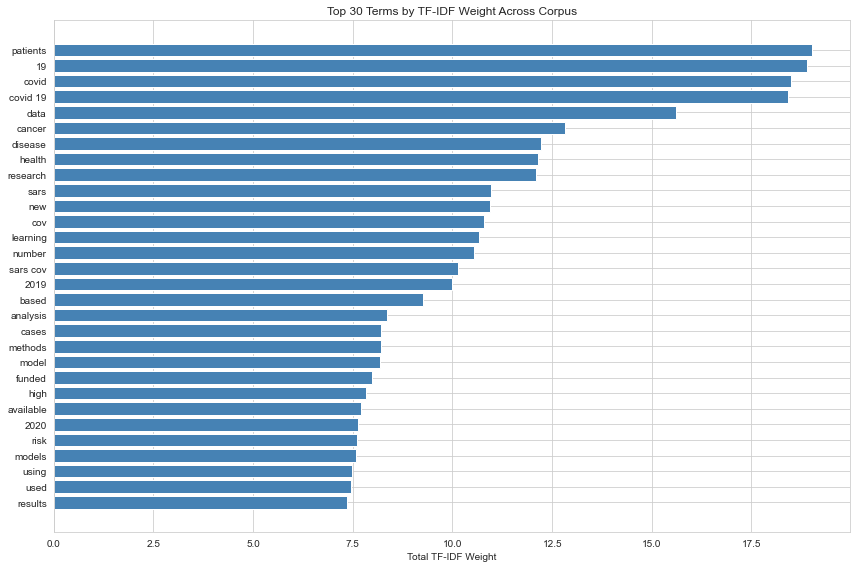

In [59]:
# Visualize top terms
fig, ax = plt.subplots(figsize=(12, 8))
top_terms = term_df.head(30)
ax.barh(range(len(top_terms)), top_terms['total_tfidf'], color='steelblue')
ax.set_yticks(range(len(top_terms)))
ax.set_yticklabels(top_terms['term'])
ax.invert_yaxis()
ax.set_xlabel('Total TF-IDF Weight')
ax.set_title('Top 30 Terms by TF-IDF Weight Across Corpus')
plt.tight_layout()
plt.show()

---

## Document Similarity

### Cosine Similarity

Once documents are represented as vectors, we can measure their similarity. **Cosine similarity** measures the angle between two vectors, ignoring their magnitude:

$$\text{cosine\_sim}(\mathbf{d}_1, \mathbf{d}_2) = \frac{\mathbf{d}_1 \cdot \mathbf{d}_2}{\|\mathbf{d}_1\| \|\mathbf{d}_2\|}$$

Values range from 0 (completely different) to 1 (identical).

**Why cosine similarity for text?**
- Normalizes for document length (a long and short document on the same topic should be similar)
- Works well with sparse, high-dimensional vectors
- Focuses on term overlap, not absolute frequencies

In [60]:
# Compute pairwise cosine similarities
similarity_matrix = cosine_similarity(tfidf_matrix)
print(f"Similarity matrix shape: {similarity_matrix.shape}")

Similarity matrix shape: (500, 500)


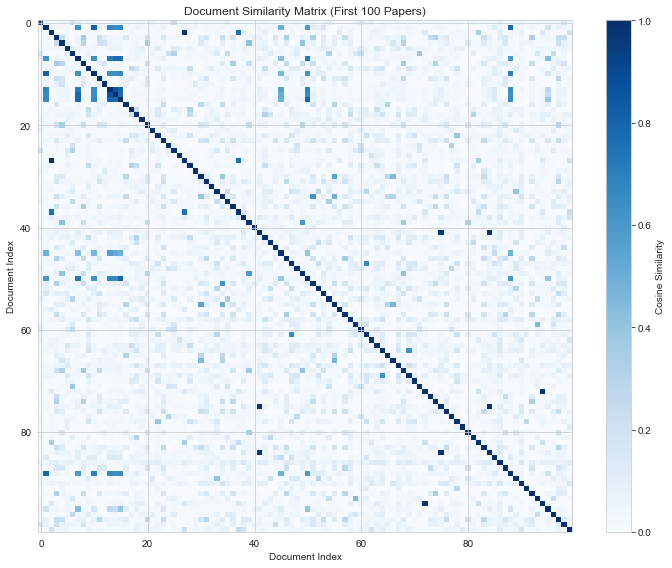

In [61]:
# Visualize similarity matrix (first 100 documents)
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(similarity_matrix[:100, :100], cmap='Blues', aspect='auto')
plt.colorbar(im, label='Cosine Similarity')
ax.set_xlabel('Document Index')
ax.set_ylabel('Document Index')
ax.set_title('Document Similarity Matrix (First 100 Papers)')
plt.tight_layout()
plt.show()

In [63]:
# Find most similar papers to a given paper
def find_similar_papers(paper_idx, similarity_matrix, papers_df, n=5):
    """Find the n most similar papers to a given paper."""
    similarities = similarity_matrix[paper_idx]
    # Get indices of top similar papers (excluding itself)
    similar_indices = np.argsort(similarities)[::-1][1:n+1]
    
    print(f"\nQuery Paper (Index {paper_idx}):")
    print(f"  Title: {papers_df.loc[paper_idx, 'title']}")
    print(f"  Field: {papers_df.loc[paper_idx, 'field']}")
    print(f"\nMost Similar Papers:")
    print("-" * 60)
    
    for rank, idx in enumerate(similar_indices, 1):
        print(f"\n{rank}. Similarity: {similarities[idx]:.3f}")
        print(f"   Title: {papers_df.loc[idx, 'title']}")
        print(f"   Field: {papers_df.loc[idx, 'field']}")

# Example: Find papers similar to the tenth paper
find_similar_papers(10, similarity_matrix, papers_df, n=5)


Query Paper (Index 10):
  Title: Global cancer statistics 2022: GLOBOCAN estimates of incidence and mortality worldwide for 36 cancers in 185 countries
  Field: Medicine

Most Similar Papers:
------------------------------------------------------------

1. Similarity: 0.809
   Title: Global Cancer Statistics 2020: GLOBOCAN Estimates of Incidence and Mortality Worldwide for 36 Cancers in 185 Countries
   Field: Medicine

2. Similarity: 0.693
   Title: Changing profiles of cancer burden worldwide and in China: a secondary analysis of the global cancer statistics 2020
   Field: Medicine

3. Similarity: 0.685
   Title: Cancer statistics for the year 2020: An overview
   Field: Medicine

4. Similarity: 0.679
   Title: Cancer statistics in China and United States, 2022: profiles, trends, and determinants
   Field: Medicine

5. Similarity: 0.666
   Title: Cancer statistics, 2023
   Field: Medicine


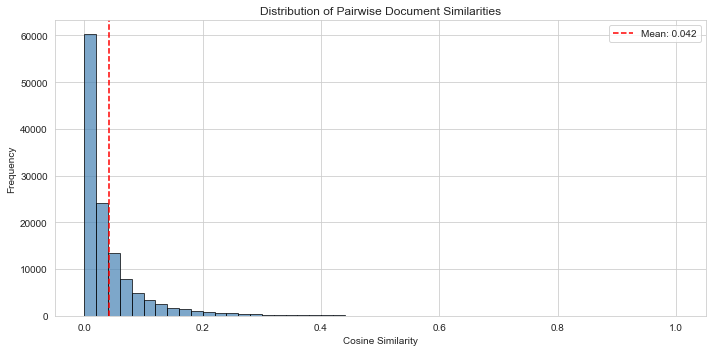


Similarity Statistics:
  Mean: 0.0420
  Median: 0.0213
  Std: 0.0635
  Min: 0.0000
  Max: 1.0000


In [64]:
# Distribution of similarity scores
# Get upper triangle of similarity matrix (excluding diagonal)
upper_triangle = similarity_matrix[np.triu_indices(len(similarity_matrix), k=1)]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(upper_triangle, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Cosine Similarity')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Pairwise Document Similarities')
ax.axvline(upper_triangle.mean(), color='red', linestyle='--', 
           label=f'Mean: {upper_triangle.mean():.3f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nSimilarity Statistics:")
print(f"  Mean: {upper_triangle.mean():.4f}")
print(f"  Median: {np.median(upper_triangle):.4f}")
print(f"  Std: {upper_triangle.std():.4f}")
print(f"  Min: {upper_triangle.min():.4f}")
print(f"  Max: {upper_triangle.max():.4f}")

In [70]:
# Find optimal number of clusters using elbow method and silhouette score
k_range = range(2, 30)
inertias = []
silhouette_scores = []

print("Evaluating cluster numbers...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++', max_iter=300)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(tfidf_matrix, kmeans.labels_))
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

Evaluating cluster numbers...
  k=2: Inertia=464.05, Silhouette=0.0243
  k=3: Inertia=458.99, Silhouette=0.0235
  k=4: Inertia=451.77, Silhouette=0.0217
  k=5: Inertia=442.65, Silhouette=0.0282
  k=6: Inertia=440.21, Silhouette=0.0282
  k=7: Inertia=430.37, Silhouette=0.0359
  k=8: Inertia=428.86, Silhouette=0.0311
  k=9: Inertia=426.55, Silhouette=0.0315
  k=10: Inertia=424.18, Silhouette=0.0308
  k=11: Inertia=421.38, Silhouette=0.0325
  k=12: Inertia=420.20, Silhouette=0.0328
  k=13: Inertia=417.23, Silhouette=0.0339
  k=14: Inertia=415.47, Silhouette=0.0331
  k=15: Inertia=411.33, Silhouette=0.0349
  k=16: Inertia=408.52, Silhouette=0.0352
  k=17: Inertia=407.17, Silhouette=0.0364
  k=18: Inertia=405.36, Silhouette=0.0356
  k=19: Inertia=402.29, Silhouette=0.0373
  k=20: Inertia=401.55, Silhouette=0.0341
  k=21: Inertia=400.42, Silhouette=0.0324
  k=22: Inertia=398.55, Silhouette=0.0335
  k=23: Inertia=396.57, Silhouette=0.0338
  k=24: Inertia=395.07, Silhouette=0.0339
  k=25: Iner

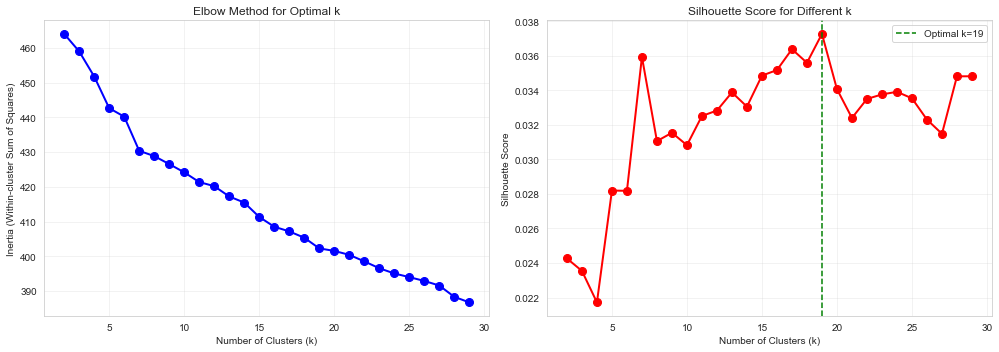


Optimal number of clusters based on silhouette score: k=19


In [71]:
# Visualize elbow and silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Silhouette plot
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Different k')
axes[1].grid(True, alpha=0.3)

# Mark optimal k based on silhouette
optimal_k = k_range[np.argmax(silhouette_scores)]
axes[1].axvline(optimal_k, color='green', linestyle='--', 
                label=f'Optimal k={optimal_k}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nOptimal number of clusters based on silhouette score: k={optimal_k}")

In [72]:
# Fit K-Means with selected number of clusters
n_clusters = 19  # You can adjust based on the analysis above

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300)
papers_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(f"Cluster Distribution:")
print(papers_df['cluster'].value_counts().sort_index())

Cluster Distribution:
0     48
1     27
2     25
3     28
4     32
5     12
6     35
7     58
8     19
9     28
10    21
11    41
12    13
13    30
14    27
15    19
16    12
17     8
18    17
Name: cluster, dtype: int64


In [73]:
# Examine cluster characteristics by looking at top terms per cluster
def get_cluster_top_terms(cluster_id, tfidf_matrix, feature_names, labels, n_terms=10):
    """Get the top terms for a specific cluster based on centroid weights."""
    cluster_docs = tfidf_matrix[labels == cluster_id]
    centroid = cluster_docs.mean(axis=0).A1  # Convert to 1D array
    top_indices = centroid.argsort()[::-1][:n_terms]
    return [(feature_names[i], centroid[i]) for i in top_indices]

feature_names = tfidf.get_feature_names_out()

print("Top 10 Terms per Cluster:")
print("=" * 70)

for cluster_id in range(n_clusters):
    cluster_size = (papers_df['cluster'] == cluster_id).sum()
    top_terms = get_cluster_top_terms(cluster_id, tfidf_matrix, feature_names, 
                                       papers_df['cluster'].values)
    print(f"\nCluster {cluster_id} (n={cluster_size}):")
    print(f"  Top terms: {', '.join([t[0] for t in top_terms])}")

Top 10 Terms per Cluster:

Cluster 0 (n=48):
  Top terms: data, global, climate, land, ms, science, industry, base, carbon, new

Cluster 1 (n=27):
  Top terms: patients, disease, 19, covid, covid 19, associated, injury, days, ct, clinical

Cluster 2 (n=25):
  Top terms: cancer, deaths, cancers, mortality, incidence, million, lung cancer, lung, alzheimer, leading

Cluster 3 (n=28):
  Top terms: guidelines, recommendations, evidence, reporting, updated, delphi, standards, quality, research, guideline

Cluster 4 (n=32):
  Top terms: cov, sars, sars cov, infection, respiratory, transmission, virus, severe, syndrome, patients

Cluster 5 (n=12):
  Top terms: attention, xlink, http www, http, w3 org, xmlns, www w3, w3, math, www

Cluster 6 (n=35):
  Top terms: image, vision, network, training, transformer, images, tasks, neural, resolution, object

Cluster 7 (n=58):
  Top terms: covid, covid 19, 19, patients, health, cases, severe, patients covid, coronavirus, pandemic

Cluster 8 (n=19):
  To

In [74]:
# Examine sample papers from each cluster
print("Sample Papers from Each Cluster:")
print("=" * 70)

for cluster_id in range(n_clusters):
    cluster_papers = papers_df[papers_df['cluster'] == cluster_id]
    print(f"\n--- Cluster {cluster_id} ({len(cluster_papers)} papers) ---")
    
    # Show 2 sample papers
    for idx, row in cluster_papers.head(2).iterrows():
        print(f"  • {row['title'][:80]}...")
        print(f"    Field: {row['field']}")

Sample Papers from Each Cluster:

--- Cluster 0 (48 papers) ---
  • The ERA5 global reanalysis...
    Field: Environmental Science
  • Early Transmission Dynamics in Wuhan, China, of Novel Coronavirus–Infected Pneum...
    Field: Medicine

--- Cluster 1 (27 papers) ---
  • Clinical Characteristics of Coronavirus Disease 2019 in China...
    Field: Medicine
  • Risk Factors Associated With Acute Respiratory Distress Syndrome and Death in Pa...
    Field: Medicine

--- Cluster 2 (25 papers) ---
  • Global Cancer Statistics 2020: GLOBOCAN Estimates of Incidence and Mortality Wor...
    Field: Medicine
  • Cancer statistics, 2020...
    Field: Economics, Econometrics and Finance

--- Cluster 3 (28 papers) ---
  • World Health Organization 2020 guidelines on physical activity and sedentary beh...
    Field: Medicine
  • One size fits all? What counts as quality practice in (reflexive) thematic analy...
    Field: Arts and Humanities

--- Cluster 4 (32 papers) ---
  • A new coronavirus assoc

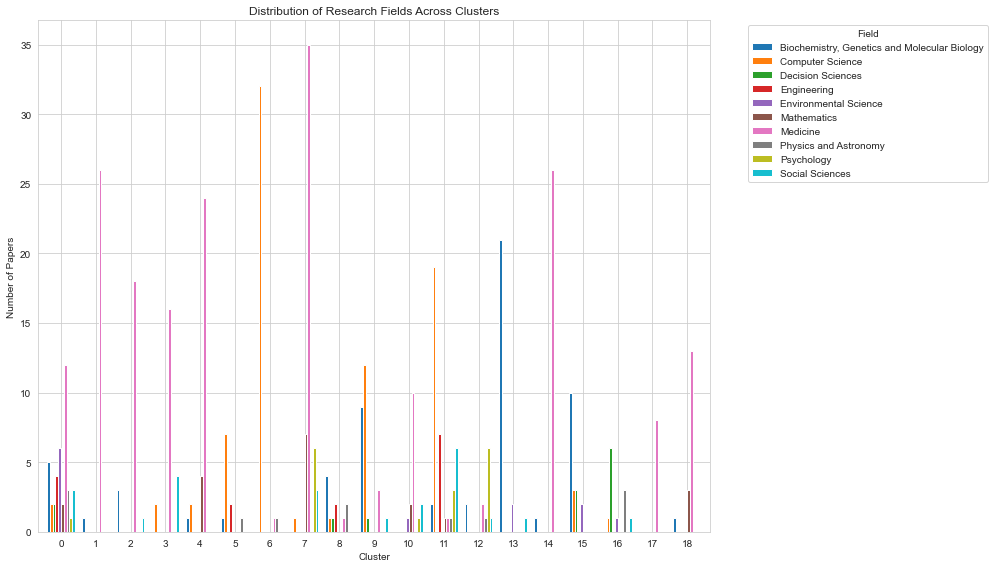

In [75]:
# Cross-tabulation: Cluster vs Field
# Get top 10 fields for cleaner visualization
top_fields = papers_df['field'].value_counts().head(10).index.tolist()
papers_top_fields = papers_df[papers_df['field'].isin(top_fields)]

crosstab = pd.crosstab(papers_top_fields['cluster'], papers_top_fields['field'])

fig, ax = plt.subplots(figsize=(14, 8))
crosstab.plot(kind='bar', ax=ax, width=0.8)
ax.set_xlabel('Cluster')
ax.set_ylabel('Number of Papers')
ax.set_title('Distribution of Research Fields Across Clusters')
ax.legend(title='Field', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

---

## Hierarchical Clustering

### Agglomerative Clustering

Unlike K-Means, hierarchical clustering does not require pre-specifying $k$. It builds a tree (dendrogram) showing the nested structure of clusters.

**Algorithm (Agglomerative - Bottom Up):**
1. Start with each document as its own cluster
2. Find the two most similar clusters and merge them
3. Repeat until all documents are in one cluster

**Linkage Methods:**
- **Single**: Distance = minimum distance between any two points
- **Complete**: Distance = maximum distance between any two points  
- **Average**: Distance = average distance between all pairs
- **Ward**: Minimizes within-cluster variance (similar to K-Means objective)

In [76]:
# Hierarchical clustering on a subset for visualization
# (Full dataset would create an unreadable dendrogram)
n_sample = 50
sample_indices = np.random.choice(len(papers_df), n_sample, replace=False)
sample_matrix = tfidf_matrix[sample_indices].toarray()
sample_papers = papers_df.iloc[sample_indices].reset_index(drop=True)

# Compute linkage matrix using Ward's method
linkage_matrix = linkage(sample_matrix, method='ward')

print(f"Computed hierarchical clustering for {n_sample} papers.")

Computed hierarchical clustering for 50 papers.


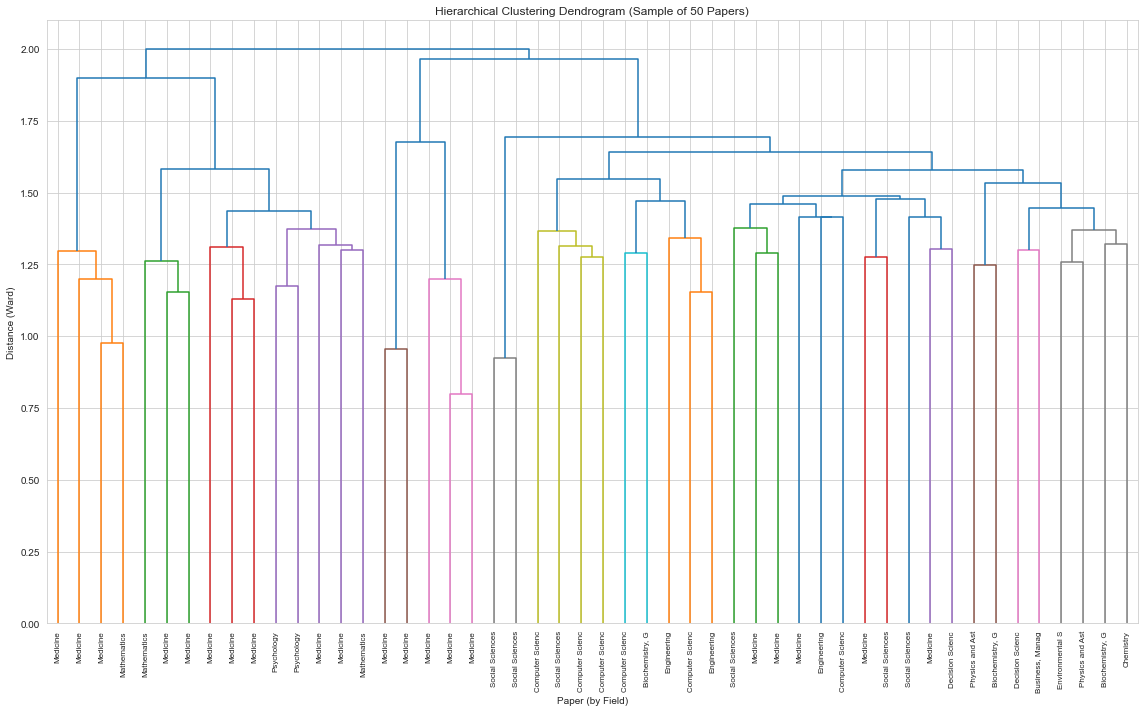

In [77]:
# Plot dendrogram
fig, ax = plt.subplots(figsize=(16, 10))

# Create labels showing field (truncated)
labels = [f"{sample_papers.loc[i, 'field'][:15]}" for i in range(n_sample)]

dendrogram(
    linkage_matrix,
    labels=labels,
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax
)

ax.set_xlabel('Paper (by Field)')
ax.set_ylabel('Distance (Ward)')
ax.set_title('Hierarchical Clustering Dendrogram (Sample of 50 Papers)')
plt.tight_layout()
plt.show()

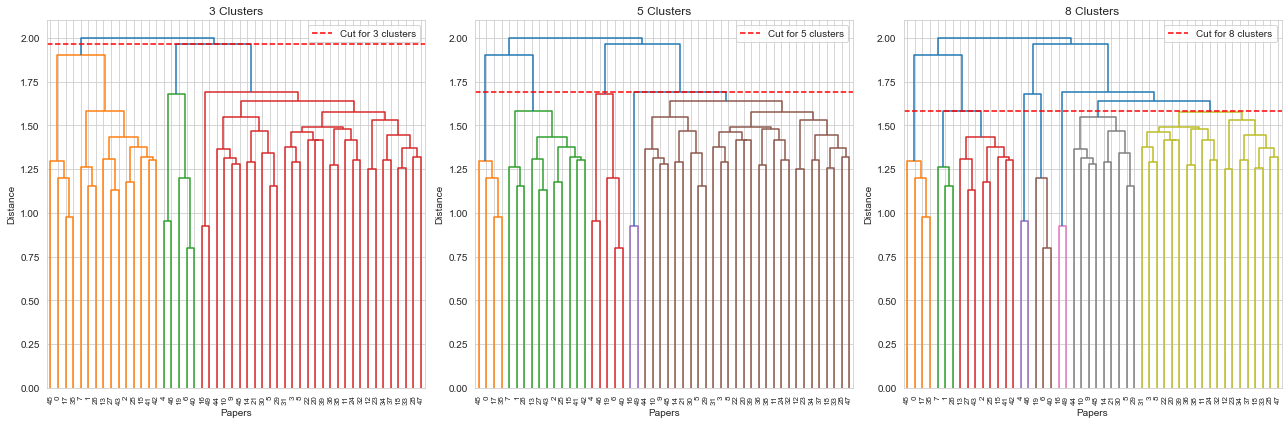

In [78]:
# Cut the dendrogram at different levels to get clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, n_clust in zip(axes, [3, 5, 8]):
    clusters = fcluster(linkage_matrix, n_clust, criterion='maxclust')
    
    # Color-coded dendrogram
    dendrogram(
        linkage_matrix,
        labels=None,
        leaf_rotation=90,
        color_threshold=linkage_matrix[-(n_clust-1), 2],
        ax=ax
    )
    ax.axhline(y=linkage_matrix[-(n_clust-1), 2], color='red', linestyle='--', 
               label=f'Cut for {n_clust} clusters')
    ax.set_title(f'{n_clust} Clusters')
    ax.set_xlabel('Papers')
    ax.set_ylabel('Distance')
    ax.legend()

plt.tight_layout()
plt.show()

---

## Part 6: Topic Modeling with Latent Dirichlet Allocation (LDA)

### From Clusters to Topics

While clustering assigns each document to one cluster, **topic modeling** assumes documents are mixtures of multiple topics.

### LDA Model

LDA is a generative probabilistic model that assumes:
1. Each **document** is a mixture of topics: $\theta_d \sim \text{Dirichlet}(\alpha)$
2. Each **topic** is a distribution over words: $\phi_k \sim \text{Dirichlet}(\beta)$
3. Each word is generated by:
   - Choosing a topic $z \sim \text{Multinomial}(\theta_d)$
   - Choosing a word $w \sim \text{Multinomial}(\phi_z)$

**Key insight**: A single paper can discuss multiple topics (e.g., methodology AND application domain), and the model learns these mixtures automatically.

**Important**: LDA uses **count vectors (BoW)**, not TF-IDF.

In [79]:
# Create count vectorizer for LDA
count_vec = CountVectorizer(
    max_features=1000,
    stop_words='english',
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)
count_matrix = count_vec.fit_transform(papers_df['abstract'])

print(f"Count matrix shape: {count_matrix.shape}")

Count matrix shape: (500, 1000)


In [82]:
# Evaluate different numbers of topics using perplexity ( lower is better)
topic_range = range(10, 30)
perplexities = []

print("Evaluating number of topics...")
for n_topics in topic_range:
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20,
        learning_method='online',
        n_jobs=-1
    )
    lda.fit(count_matrix)
    perplexity = lda.perplexity(count_matrix)
    perplexities.append(perplexity)
    print(f"  {n_topics} topics: Perplexity = {perplexity:.2f}")

Evaluating number of topics...
  10 topics: Perplexity = 536.42
  11 topics: Perplexity = 549.34
  12 topics: Perplexity = 514.86
  13 topics: Perplexity = 511.16
  14 topics: Perplexity = 515.57
  15 topics: Perplexity = 492.88
  16 topics: Perplexity = 515.08
  17 topics: Perplexity = 511.87
  18 topics: Perplexity = 510.60
  19 topics: Perplexity = 526.12
  20 topics: Perplexity = 497.69
  21 topics: Perplexity = 517.41
  22 topics: Perplexity = 505.74
  23 topics: Perplexity = 521.15
  24 topics: Perplexity = 503.70
  25 topics: Perplexity = 535.71
  26 topics: Perplexity = 517.65
  27 topics: Perplexity = 513.43
  28 topics: Perplexity = 513.01
  29 topics: Perplexity = 519.66


Perplexity is a measurement used in information theory to evaluate how well a probability model predicts a sample.
In the context of Topic Modeling (like LDA), it measures the model's "surprise" when encountering new, unseen data.

Imagine your model is reading a new document word by word.
- High Perplexity: The model is "perplexed" (confused). It did not expect the words it is seeing. This implies a poor understanding of the text's structure.
- Low Perplexity: The model is not surprised. It accurately predicted the distribution of words. This implies a good statistical understanding.

The Golden Rule : Lower is Better.

A lower perplexity score indicates that the model generalizes well and has a high predictive accuracy for the dataset.

Mathematically, perplexity is the inverse probability of the test set, normalized by the number of words. It is often defined as the exponentiation of the cross-entropy:$$\text{Perplexity} = 2^{-\sum p(x) \log_2 p(x)}$$

If a model has a perplexity of 100, it is essentially as confused as if it were choosing between 100 equally likely words for the next position. 

*obs* Perplexity does not always correlate with Human Interpretability.A model can have a very low perplexity (statistically perfect) but produce topics that look like random gibberish to a human.Therefore, it is best used in combination with Topic Coherence, which measures semantic readability.

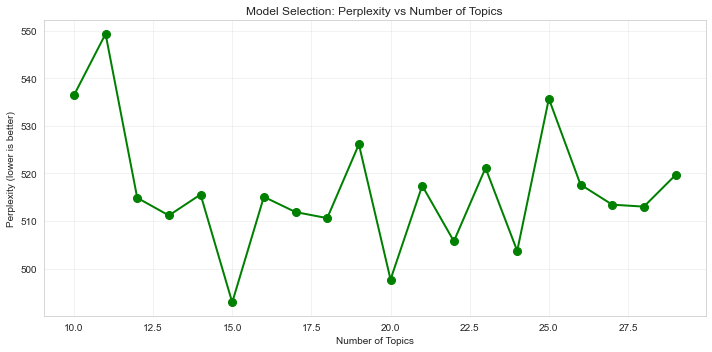

In [83]:
# Plot perplexity vs number of topics
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(topic_range, perplexities, 'go-', linewidth=2, markersize=8)
ax.set_xlabel('Number of Topics')
ax.set_ylabel('Perplexity (lower is better)')
ax.set_title('Model Selection: Perplexity vs Number of Topics')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [84]:
# Fit LDA with selected number of topics
n_topics = 15

lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=30,
    learning_method='batch',  # batch for smaller datasets
    n_jobs=-1
)

# Get document-topic distributions
doc_topic_dist = lda.fit_transform(count_matrix)

print(f"Document-Topic matrix shape: {doc_topic_dist.shape}")
print(f"  - {doc_topic_dist.shape[0]} documents")
print(f"  - {doc_topic_dist.shape[1]} topics")

Document-Topic matrix shape: (500, 15)
  - 500 documents
  - 15 topics


In [85]:
# Display top words for each topic
def display_topics(model, feature_names, n_top_words=15):
    """Display the top words for each topic."""
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics[topic_idx] = top_words
        print(f"\nTopic {topic_idx}:")
        print(f"  {', '.join(top_words)}")
    return topics

feature_names = count_vec.get_feature_names_out()
print("Top 15 Words per Topic:")
print("=" * 70)
topic_words = display_topics(lda, feature_names, n_top_words=15)

Top 15 Words per Topic:

Topic 0:
  data, new, database, https, abstract, including, protein, information, annotation, release, gene, tools, sequences, tree, access

Topic 1:
  learning, image, model, performance, models, tasks, large, vision, transformer, training, data, networks, detection, deep, paper

Topic 2:
  19, covid, covid 19, patients, severe, disease, cases, coronavirus, clinical, symptoms, care, 2020, days, study, 2019

Topic 3:
  number, funded, gov, clinicaltrials gov, clinicaltrials, gov number, positive, patients, negative, pcr, survival, results, support, free, group

Topic 4:
  research, guidelines, responses, questions, published, health, researchers, quality, land, use, provide, recommendations, patient, document, industry

Topic 5:
  data, available, based, new, analysis, abstract, web, features, source, use, number, users, genome, version, functional

Topic 6:
  www, http www, http, math, org, xmlns, w3, www w3, w3 org, display, samples, approximately, data, vari

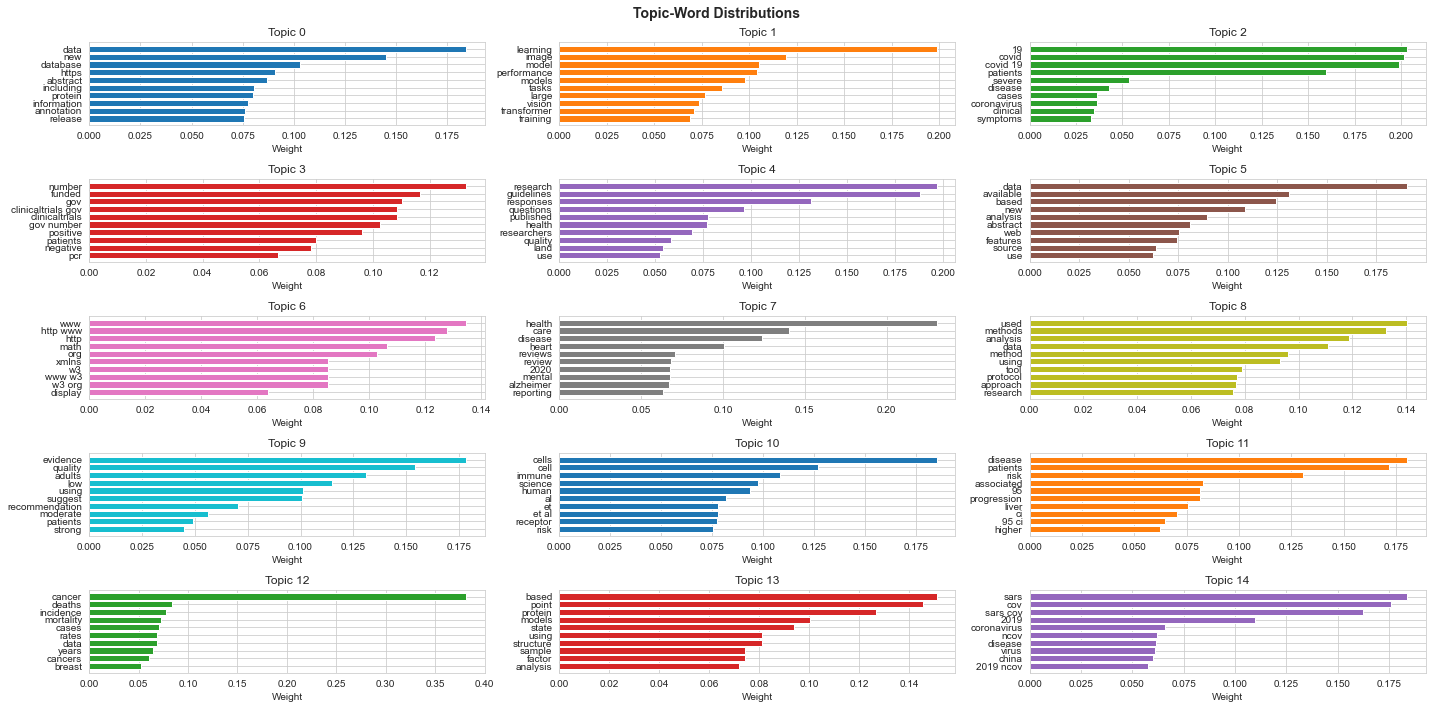

In [87]:
# Visualize topic-word distributions
fig, axes = plt.subplots(5, 3, figsize=(20, 10))
axes = axes.flatten()

for topic_idx in range(n_topics):
    ax = axes[topic_idx]
    top_words_idx = lda.components_[topic_idx].argsort()[:-11:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_weights = lda.components_[topic_idx][top_words_idx]
    
    # Normalize weights for visualization
    top_weights = top_weights / top_weights.sum()
    
    ax.barh(range(len(top_words)), top_weights, color=f'C{topic_idx}')
    ax.set_yticks(range(len(top_words)))
    ax.set_yticklabels(top_words)
    ax.invert_yaxis()
    ax.set_xlabel('Weight')
    ax.set_title(f'Topic {topic_idx}')

plt.suptitle('Topic-Word Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [88]:
# Assign dominant topic to each paper
papers_df['dominant_topic'] = doc_topic_dist.argmax(axis=1)
papers_df['topic_confidence'] = doc_topic_dist.max(axis=1)

print("Topic Assignment Distribution:")
print(papers_df['dominant_topic'].value_counts().sort_index())

Topic Assignment Distribution:
0     35
1     98
2     71
3     24
4     39
5     43
6      2
7     41
8     19
9      2
10    16
11    17
12    26
13     9
14    58
Name: dominant_topic, dtype: int64


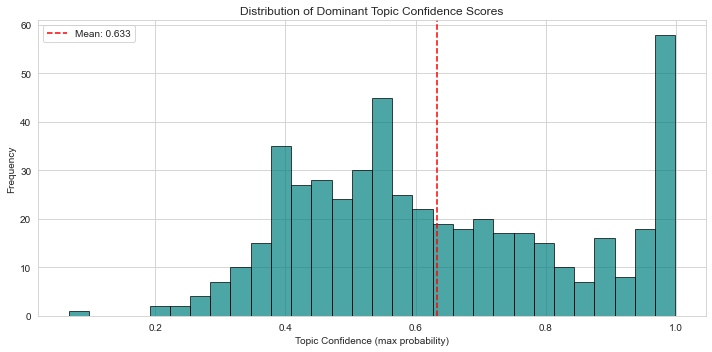


Mean topic confidence: 0.633
This indicates how 'pure' documents are (higher = more focused on single topic)


In [89]:
# Distribution of topic confidence scores
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(papers_df['topic_confidence'], bins=30, edgecolor='black', alpha=0.7, color='teal')
ax.set_xlabel('Topic Confidence (max probability)')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Dominant Topic Confidence Scores')
ax.axvline(papers_df['topic_confidence'].mean(), color='red', linestyle='--',
           label=f'Mean: {papers_df["topic_confidence"].mean():.3f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"\nMean topic confidence: {papers_df['topic_confidence'].mean():.3f}")
print(f"This indicates how 'pure' documents are (higher = more focused on single topic)")

In [90]:
# Example: Show topic mixture for sample papers
def show_paper_topics(paper_idx, doc_topic_dist, papers_df, topic_words):
    """Display the topic distribution for a specific paper."""
    print(f"\nPaper: {papers_df.loc[paper_idx, 'title'][:80]}...")
    print(f"Field: {papers_df.loc[paper_idx, 'field']}")
    print(f"\nTopic Distribution:")
    
    topic_probs = doc_topic_dist[paper_idx]
    sorted_topics = np.argsort(topic_probs)[::-1]
    
    for topic_idx in sorted_topics[:3]:  # Top 3 topics
        if topic_probs[topic_idx] > 0.05:  # Only show if > 5%
            top_words = ', '.join(topic_words[topic_idx][:5])
            print(f"  Topic {topic_idx} ({topic_probs[topic_idx]:.1%}): {top_words}")

# Show examples
print("Example Topic Mixtures:")
print("=" * 70)
for idx in [0, 50, 100, 200]:
    show_paper_topics(idx, doc_topic_dist, papers_df, topic_words)

Example Topic Mixtures:

Paper: Radiation Resistant Camera System for Monitoring Deuterium Plasma Discharges in ...
Field: Physics and Astronomy

Topic Distribution:
  Topic 1 (54.1%): learning, image, model, performance, models
  Topic 11 (34.8%): disease, patients, risk, associated, 95
  Topic 5 (8.4%): data, available, based, new, analysis

Paper: Cancer statistics, 2024...
Field: Medicine

Topic Distribution:
  Topic 12 (99.3%): cancer, deaths, incidence, mortality, cases

Paper: Dysregulation of Immune Response in Patients With Coronavirus 2019 (COVID-19) in...
Field: Medicine

Topic Distribution:
  Topic 2 (98.1%): 19, covid, covid 19, patients, severe

Paper: The Epidemiological Characteristics of an Outbreak of 2019 Novel Coronavirus Dis...
Field: Mathematics

Topic Distribution:
  Topic 2 (50.8%): 19, covid, covid 19, patients, severe
  Topic 14 (34.6%): sars, cov, sars cov, 2019, coronavirus
  Topic 12 (14.0%): cancer, deaths, incidence, mortality, cases


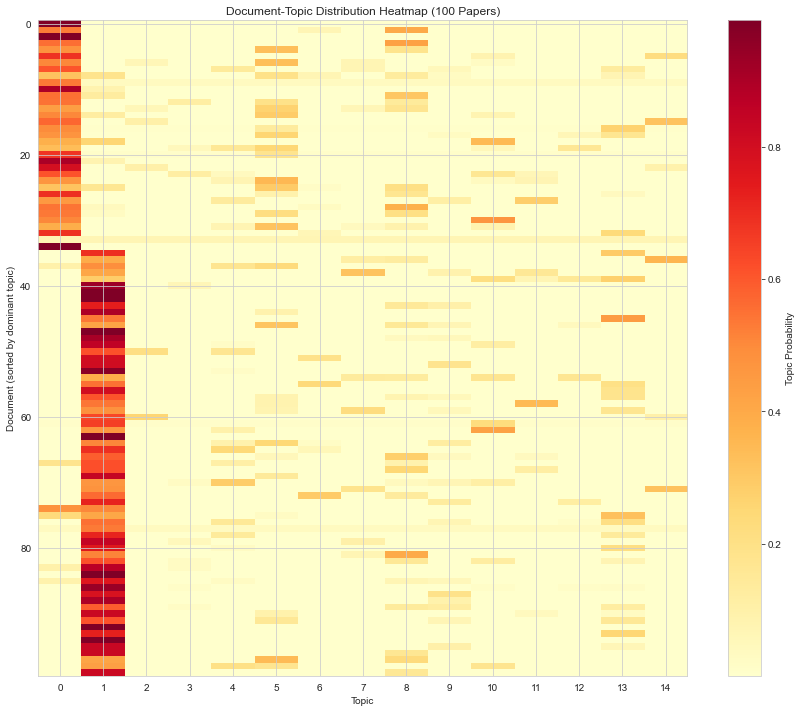

In [91]:
# Visualize document-topic heatmap (subset of documents)
fig, ax = plt.subplots(figsize=(12, 10))

# Sort documents by dominant topic for cleaner visualization
sorted_indices = np.argsort(papers_df['dominant_topic'].values)
sorted_doc_topic = doc_topic_dist[sorted_indices][:100]  # First 100 after sorting

im = ax.imshow(sorted_doc_topic, aspect='auto', cmap='YlOrRd')
plt.colorbar(im, label='Topic Probability')
ax.set_xlabel('Topic')
ax.set_ylabel('Document (sorted by dominant topic)')
ax.set_title('Document-Topic Distribution Heatmap (100 Papers)')
ax.set_xticks(range(n_topics))
plt.tight_layout()
plt.show()

---

## Part 7: Comparing Clustering and Topic Modeling

Let's compare how K-Means clustering and LDA topic modeling partition the same corpus.

In [92]:
# Cross-tabulation: K-Means Cluster vs LDA Dominant Topic
print("K-Means Cluster vs LDA Dominant Topic:")
print(pd.crosstab(papers_df['cluster'], papers_df['dominant_topic'], margins=True))

K-Means Cluster vs LDA Dominant Topic:
dominant_topic   0   1   2   3   4   5  6   7   8  9  10  11  12  13  14  All
cluster                                                                      
0                8   1   0   1   8  11  0   2   3  0   5   2   2   1   4   48
1                0   0  19   1   0   0  0   0   0  0   1   6   0   0   0   27
2                1   0   0   0   0   0  0   4   1  0   1   0  18   0   0   25
3                1   0   0   1  12   1  0   7   1  1   2   0   1   0   1   28
4                1   0   5   0   0   0  0   0   0  0   2   0   0   0  24   32
5                0   8   0   0   0   1  1   0   1  0   0   0   0   1   0   12
6                1  34   0   0   0   0  0   0   0  0   0   0   0   0   0   35
7                0   0  37   1   2   0  0   5   0  0   1   1   1   0  10   58
8                1   3   0   0   1  10  0   0   3  0   0   0   0   1   0   19
9                3  16   0   0   2   2  0   1   1  0   1   0   0   2   0   28
10               0   1   

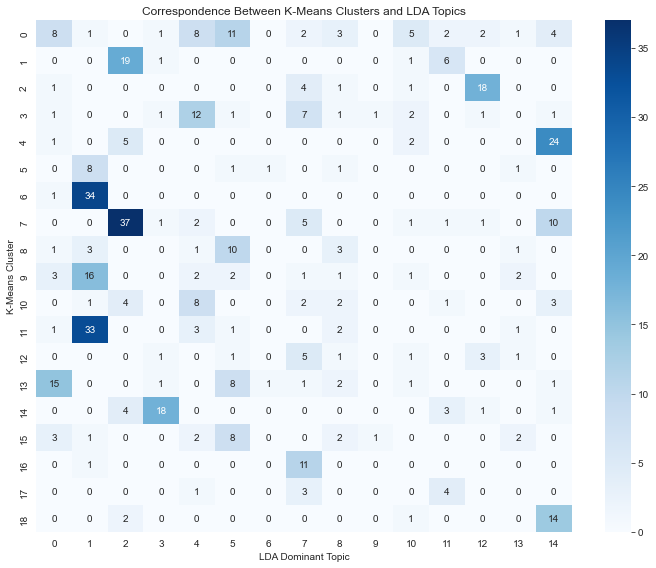

In [94]:
# Heatmap of cluster-topic correspondence
crosstab = pd.crosstab(papers_df['cluster'], papers_df['dominant_topic'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('LDA Dominant Topic')
ax.set_ylabel('K-Means Cluster')
ax.set_title('Correspondence Between K-Means Clusters and LDA Topics')
plt.tight_layout()
plt.show()

---

## Key Takeaways

### Text Representation
- **Bag of Words (BoW)**: Simple term frequency counts; useful for LDA
- **TF-IDF**: Weights terms by discriminative power; better for clustering and similarity

### Document Similarity
- **Cosine similarity** measures angle between document vectors
- Works well with sparse, high-dimensional text representations
- Enables finding similar documents and building recommendation systems

### Clustering Methods
- **K-Means**: Fast, scalable, assigns each document to exactly one cluster
  - Requires specifying $k$ beforehand
  - Use elbow method and silhouette score for selection
- **Hierarchical clustering**: Creates nested structure (dendrogram)
  - No need to pre-specify $k$
  - Less scalable to large corpora

### Topic Modeling
- **LDA** discovers latent topics as distributions over words
- Documents are **mixtures** of topics (soft assignment)
- More interpretable for understanding thematic structure
- Requires count vectors, not TF-IDF

### When to Use What
| Task | Method | Rationale |
|------|--------|-----------|
| Hard document grouping | K-Means | Clear, discrete clusters |
| Exploring cluster hierarchy | Hierarchical | Visual dendrogram |
| Understanding thematic structure | LDA | Interpretable topics |
| Multi-topic documents | LDA | Soft assignment |
| Large-scale clustering | K-Means | Computational efficiency |

---

## Exercises

1. **Modify the TF-IDF parameters**: Experiment with different `max_features`, `min_df`, and `max_df` values. How do they affect clustering quality?

2. **Try different numbers of topics**: Fit LDA with 5, 10, and 15 topics. Which produces the most interpretable topics?

3. **Filter by field**: Select papers from a specific field (e.g., Medicine, Computer Science) and run clustering. Are the subtopics more coherent?

4. **Combine title and abstract and clean!**: Create a new text column combining title and abstract, take care about "cleaning". Does this improve clustering?

---

## References

- Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent Dirichlet Allocation. *Journal of Machine Learning Research*, 3, 993-1022.
- Gentzkow, M., Kelly, B., & Taddy, M. (2019). Text as Data. *Journal of Economic Literature*, 57(3), 535-574.
- OpenAlex Documentation: https://docs.openalex.org/
- scikit-learn Documentation: https://scikit-learn.org/stable/modules/clustering.html